# Segmentation

This notebook explores the segmentation function of tobac and its parameters.

In [60]:
import tobac
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

%matplotlib inline

To perform a segmentation we need a dataset with already detected features. Therefore, we take advantage of the *testing.make_sample_data_2D_3blobs_inv()*-utility and detect features with different thresholds:

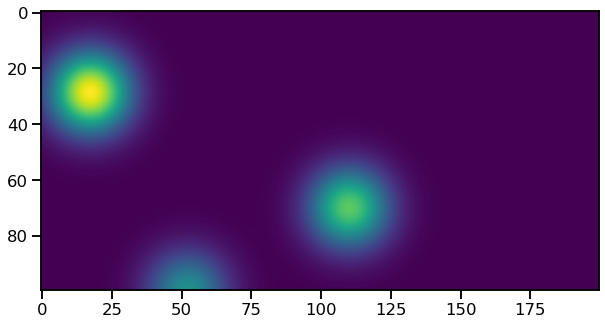

In [38]:
data = tobac.testing.make_sample_data_2D_3blobs_inv()
dxy, dt = tobac.utils.get_spacings(data)
thresholds = [9, 14, 17]
plt.figure(figsize = (10, 10))
plt.imshow(data[50])
plt.show()

In [39]:
%%capture
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, thresholds)

The resulting dataset can now be used as argument for the *segmentation()*-function. The other required inputs are the original dataset, the spacing and a threshold. It is important to highlight that segmentation is onyl possible with single threshold values. Because of that, we have to call the function multiple times to explore the influence of the threshold:

In [40]:
%%capture
mask_1, features_mask_1 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=9)
mask_2, features_mask_2 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=14)
mask_3, features_mask_3 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=17)

The created segments are provided as masks, which is the first returned object of the function. The second output is the features-Dataset again, but with the additional *ncells*-variable, which gives us the number of datapoints belonging to the feature:

In [41]:
features_mask_1['ncells'][1]

<xarray.DataArray 'ncells' ()>
array(67.)
Coordinates:
    index    int64 1

Notice that this number can be deviate from the *num*-value, because watershedding works differently from just detecting the values exceeeding the threshold. For example, for the second feature *ncells* contains one additional datapoint compared to the original feature detection:

In [42]:
features_mask_1['num'][1]

<xarray.DataArray 'num' ()>
array(66)
Coordinates:
    index    int64 1

To visualize the segments we can use contour-plots of the masks:

Text(0.5, 1.0, 'Segments for different threshold values')

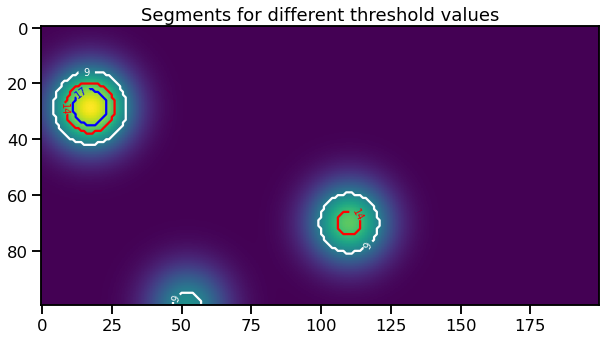

In [43]:
masks = [mask_1, mask_2, mask_3]
colors = ['white', 'red', 'blue']

fig, ax = plt.subplots(ncols = 1, figsize = (10, 10))
ax.imshow(data[50])

for n, mask, color in zip(thresholds, masks, colors):

    CS = ax.contour(mask[50]*n, levels = [n], colors = color)
    ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('Segments for different threshold values')

Obviously, a lower threshold value prodcuces a larger segment and if a feature does not exceed the value at all, no segment is associated.

## Method

The segmentation uses certain techniques to associate areas or volumes to each identified feature. [Watershedding](https://en.wikipedia.org/wiki/Watershed_(image_processing)) is the default and the only implemented option at the moment, but in future realeases the method is selected by the *method*-keyword:

In [44]:
%%capture
mask_1, features_mask_1 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=9, method = 'watershed')

## Target

Analogous to the feature detection, it is also possible to apply the segmantation to minima by changing the *target* keyword:

In [45]:
%%capture

data = -tobac.testing.make_sample_data_2D_3blobs_inv()
dxy, dt = tobac.utils.get_spacings(data)
thresholds = [-9, -14, -17]
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, thresholds, target='minimum')

mask_1, features_mask_1 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=-9, target='minimum')
mask_2, features_mask_2 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=-14, target='minimum')
mask_3, features_mask_3 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=-17, target='minimum')

Text(0.5, 1.0, 'Segments for different threshold values')

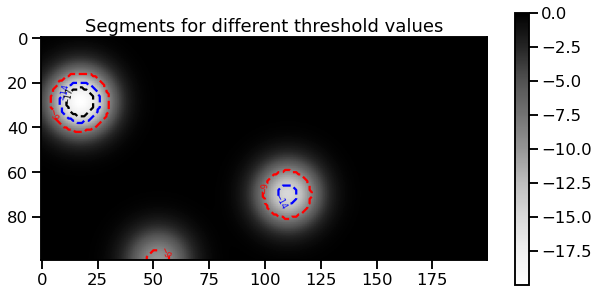

In [46]:
masks = [mask_1, mask_2, mask_3]
colors = ['red', 'blue', 'black']

fig, ax = plt.subplots(ncols = 1, figsize = (10, 10))
image = ax.imshow(data[50], cmap = 'Greys')
plt.colorbar(image, shrink = 0.5)

for n, mask, color in zip(thresholds, masks, colors):

    CS = ax.contour(mask[50]*n, levels = [n], colors = color)
    ax.clabel(CS, inline=True, fontsize = 8)

ax.set_title('Segments for different threshold values')

## max_distance 

Another way of determining the size of our segments is the *max_distance*-parameter. It defines a maximum distance the segment can have from the coordinates of feature (in meters). This enables us, for example, to ensure that the segments of different features do not touch each other when we use a very low threshold value:

In [47]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs_inv()
dxy, dt = tobac.utils.get_spacings(data)
thresh = 0.1

features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=3)
mask = features['frame'] == 50

mask_0, features_0 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=thresh)

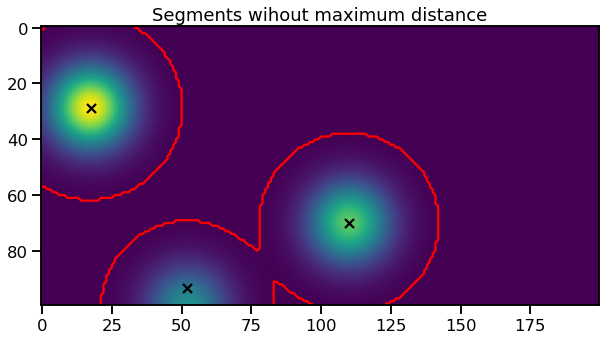

In [48]:
plt.figure(figsize = (10, 10))
plt.imshow(data[50])
plt.contour(mask_0[50], levels = [0.5], colors = 'red')
plt.title('Segments wihout maximum distance')
plt.scatter(features.where(mask)['hdim_2'], features.where(mask)['hdim_1'], marker = 'x', color = 'black')
plt.show()

In [49]:
%%capture

mask_1, features_mask_1 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=thresh, max_distance=20000)
mask_2, features_mask_2 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=thresh, max_distance=10000)
mask_3, features_mask_3 = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=thresh, max_distance=5000)

Text(0.5, 1.0, 'Segments for different maximum distances')

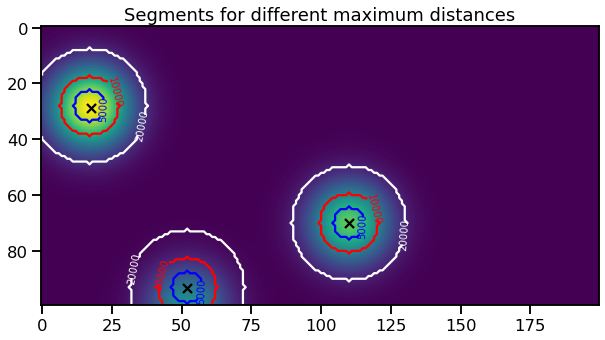

In [50]:
masks = [mask_1, mask_2, mask_3]
colors = ['white', 'red', 'blue']
distances = [2e4, 1e4, 5e3]
fig, ax = plt.subplots(ncols = 1, figsize = (10, 10))

ax.imshow(data[50])
ax.scatter(features.where(mask)['hdim_2'], features.where(mask)['hdim_1'], marker = 'x', color = 'black')

for n, mask, color in zip(distances, masks, colors):

    CS = ax.contour(mask[50]*n, levels = [n], colors = color)
    ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('Segments for different maximum distances')

## level and vertical_coord

The remaining parameters *level* and *vertical_coord* are useful only for the segemtation of 3-dimensional inputs and will be covered in the notebook for 3d-data